# Cài đặt

In [1]:
#requirements
!pip install --no-cache-dir --user grad_cam
!pip install --no-cache-dir --user torch
%cd /content/drive/MyDrive/TTDPT/CutMix-PyTorch/
import torch
import resnet as RN
import torchvision.transforms as transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 300
import cv2
import numpy as np
np.random.seed(1999)
import pandas as pd
pd.set_option('display.colheader_justify', 'center')
import io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/drive/MyDrive/TTDPT/CutMix-PyTorch


# 1. Giới thiệu bài toán

- Các phương pháp sử dụng các mô hình trí tuệ nhân tạo đã và đang giải quyết hiệu quả các bài toán thực tiễn được đặt ra ví dụ: Ứng dụng xe tự hành, Trợ lý ảo, Tính năng dịch tự động, ... Các bài toán này xuất phát từ các bài toán cơ bản như phân loại đối tượng, xác định vị trí đối tượng, trích xuất đối tượng, ...

- Các mô hình trí tuệ nhân tạo sẽ có kiến trúc cụ thể, và kiến trúc đó được huấn luyện học tập trên các tập dữ liệu. Rất nhiều dữ liệu được gán nhãn được đổ vào để có thể huấn luyện mô hình một cách hiệu quả nhất. Các dữ liệu được gán nhãn dựa trên tương tác của con người để có kết quả chính xác nhất. Đây là một quá trình mất nhiều thời gian và công sức để đạt được một tập dữ liệu đủ lớn cho các bài toán cũng như mô hình trí tuệ nhân tạo. Để có thể đạt được các mô hình với độ chính xác cao và cao hơn, các chiến lược huấn luyện mô hình được đề xuất, bao gồm tăng cường dữ liệu và chỉnh sửa mô hình.

- Trong thực tế, để một mô hình trí tuệ nhân tạo không quá tập trung vào một tập dữ liệu hoặc một phần của dữ liệu đầu vào, các phương pháp lược bỏ ngẫu nhiên một phần kiến trúc mô hình được đề xuất. Phương pháp Dropout lược bỏ ngẫu nhiên các liên kết giữa các lớp trong mô hình, từ đó xóa ngẫu nhiên một phần của dữ liệu đầu vào. Các nghiên cứu đã chỉ ra rằng phương pháp trên tăng tính tổng quát cho mô hình, các mô hình không chỉ tập trung vào vùng khác biệt nhất của các dữ liệu đầu vào mà sẽ học sự khác nhau của các vùng khác. Bên cạnh các phương pháp thay đổi kiến trúc mô hình, các phương pháp tác động trực tiếp vào dữ liệu đầu vào. Các vùng ngẫu nhiên của dữ liệu sẽ bị xóa hoặc thay vào đó là các giá trị nhiễu ngẫu nhiên. Các phương pháp này cải thiện độ chính xác của các mô hình, tuy nhiên nhiều thông tin có giá trị bị lược bỏ trong quá trình huấn luyện. 

- Phương pháp CutMix được đề xuất như một phương pháp giải quyết vấn đề trên. Thay vì xóa các giá trị ngẫu nhiên của dữ liệu đầu vào, phương pháp thay thế các vùng bị xóa thành các giá trị từ các dữ liệu đầu vào khác. Nhãn của dữ liệu đầu vào mới này là tổng hợp nhãn của các phần được sử dụng. Phương pháp đề xuất tạo ra nguồn dữ liệu với các thông tin có giá trị mà vẫn tận dụng được tính tổng quan như các phương pháp trên khi mô hình sẽ không tập trung vào một vùng cố định. Tính tổng quan của mô hình là việc mô hình đó giải quyết tốt vấn đề được đề xuất với các dữ liệu không có trong tập dữ liệu được huấn luyện.

# 2.Các phương pháp liên quan


- Dropout: Phương pháp này ngẫu nhiên xóa bỏ một phần của ảnh. Phương pháp được đề xuất để cải thiện tính tổng quan của các mô hình trí tuệ nhân tạo. Các bài toán xác định vị trí đối tượng trong ảnh cũng sử dụng phương pháp này để tăng độ chính xác của kết quả đầu ra. Phương pháp CutMix được đề xuất có điểm tương đồng với phương pháp này là việc cùng thay đổi thành phần trong ảnh. Tuy nhiên, CutMix sử dùng một phần dữ liệu trong tập dữ liệu để thay thế.
- DropBlock: Các mô hình trí tuệ nhân tạo sẽ tạo ra các feature map, là một mảng các thông tin được trích xuất từ ảnh. Phương pháp này ngẫu nhiên xóa bỏ một phần của feature map, từ đó cũng cải thiện tính tổng quan của mô hình. Phương pháp CutMix được đề xuất cũng có thể được thực hiện trên các feature map như trên, và được thể hiện ở phần Đánh giá.
- Stylizing ImageNet: Một số phương pháp phát triển các mô hình trí tuệ nhân tạo, các mô hình này học từ các tập dữ liệu có sẵn và sinh ra các dữ liệu nhân tạo, các mẫu dữ liệu huấn luyện mới này sẽ hướng dẫn các mô hình học tập trung vào hình dạng của đối tượng hơn là kết cấu của đối tượng. Có thể lấy ví dụ cho hình dạng của đối tượng là hình dạng con người và kết cấu đối tượng là con người đó mặc gì, trông như thế nào. Cách làm này cải thiện khả năng phân loại và xác định vị trí đối tượng của các mô hình. Cho bài toán phân loại đối tượng, các phương pháp họ Stylish kết hợp hình dạng của đối tượng với các kết cấu bên trong không thuộc loại đối tượng đó, từ đó tạo ra dữ liệu mới tốt hơn cho việc phân loại dựa vào hình dạng. Về bài toán xác định vị trí đối tượng, các phương pháp đề xuất việc thêm các đối tượng vào các ảnh nền khác nhau. Mục đích của các phương pháp này là để đạt được mô hình tốt hơn trong việc xác định vị trí của các đối tượng đơn lẻ, trong khi phương pháp đề xuất CutMix tạo ra các mẫu dữ liệu để đạt được mô hình tốt hơn trong việc xác định vị trí của nhiều đối tượng cùng lúc.
- Mixup: Phương pháp CutMix có sự tương đồng với phương pháp Mixup trong việc kết hợp 2 mẫu dữ liệu với nhau, và nhãn dán của mẫu dữ liệu mới này cũng là sự kết hợp bởi nội suy tuyến tính giữa nhãn của 2 mẫu. Từ các thực nghiệm, phương pháp Mixup đưa ra các mẫu dữ liệu mơ hồ và không thực tiễn, từ đó làm các mô hình trí tuệ nhân tạo bị nhầm lẫn, đặc biệt là trong bài toán xác định vị trí đối tượng.

# 3. Phương pháp đề xuất

Thuật toán:
Trong các bộ dữ liệu dạng ảnh, một dữ liệu sẽ bao gồm một ảnh và nhãn dán của ảnh đó. Ảnh sẽ được ký hiệu là  $x ∈ R^{H*W*C}$ và nhãn dán của ảnh sẽ được ký hiệu là y. Một cách rõ ràng hơn, ảnh sẽ là một mảng 2 chiều các pixel, có chiều dài là H và chiều rộng là W. Một pixel sẽ gồm 3 giá trị đại diện cho 3 kênh màu: dỏ (Red), xanh lá (Green) và xanh dương (Blue). Nhãn $y$ của ảnh có thể là phân loại của đối tượng đó, ví dụ: chó, mèo, ô tô, xe máy, ...; hoặc là vị trí của các đối tượng theo giá trị pixel trong ảnh cho bài toán xác định vị trí.
Mục tiêu của phương pháp CutMix là tạo ra dữ liệu huấn luyện mới $(\tilde{x}, \tilde{y})$ bằng cách kết hợp 2 mẫu dữ liệu có sẵn $(x_A, y_A)$ vaf $(x_B, y_B)$. Phương pháp kết hợp được định nghĩa như sau:<br>
$$\tilde{x} = M \cdot x_A + (1-M) ⋅ x_B$$ <br>
$$\tilde{y} = λ y_A + (1-λ) y_B$$ <br>
Trong đó $M$ định nghĩa cho vùng cần giữ lại của ảnh $x_A$ và $1-M$ định nghĩa cho vùng thay thế của ảnh $x_B$ vào ảnh $x_A$. Phép nhân giữa ảnh M với ảnh A là phép nhân element-wise, các pixel tại vị trí tương ứng nhân với nhau để tạo thành pixel của ảnh $\tilde{x}$.<br>
Giá trị của $λ$ được lấy mẫu ngẫu nhiên trong khoảng $(0, 1)$ theo phân bố đều. Phương pháp đề xuất CutMix thay thế các vùng bằng ảnh từ trong cùng tập dữ liệu, từ đó tạo ra mẫu dữ liệu mới có tính thực tiễn cao.<br>
Phương pháp tạo ra vùng thay thế $M$ sẽ dựa theo giá trị của $λ$. Vị trí vùng thay thế M sẽ được định nghĩa bằng 4 giá trị $positionM = (r_x,r_y,r_w,r_h)$, trong đó $(r_x,r_y)$ biểu diễn vị trí pixel bắt đầu của vùng thay thế $M$, và $(r_w,r_h)$ lần lượt là chiều rộng và chiều dài của vùng $M$. Vùng $M$ tại ảnh $x_A$ sẽ được thay thế bằng vùng $M$ tại ảnh $x_B$.
Các giá trị chiều rộng $r_w$ và $r_h$ được tính theo công thức:<br>
$$r_w = W \sqrt{1-λ}$$<br>
$$r_h = H \sqrt{1-λ}$$<br>
Diện tích của vùng thay thế $M$: $r_wr_h = (1-λ)WH$. Tỉ lệ diện tích của vùng $M$ và ảnh $x_A$ và $x_B$ là tỉ lệ khi tổng hợp nhãn dán mới $\tilde{y}$ bằng nhãn dán của 2 ảnh $y_A$ và $y_B$ theo nội suy tuyến tính.<br>
Giá trị $r_x$ và $r_y$ được lấy mẫu lần lượt trong khoảng $(0, W-r_w)$ và $(0, H-r_h)$ theo phân bố đều.<br>
Trong quá trình huấn luyện các mô hình trí tuệ nhân tạo, phương pháp CutMix tạo ra một dữ liệu mới $(\tilde{x},\tilde{y})$ bằng cách kết hợp ngẫu nhiên 2 dữ liệu từ tập dữ liệu gốc.  Phương pháp được đề xuất chỉ phát sinh một lượng tính toán nhỏ trong quá trình huấn luyện và có thể được triển khai một cách dễ dàng vào việc huấn luyện các mô hình trí tuệ nhân tạo.<br>
Hình ảnh bên dưới là ví dụ với ảnh $x_A$ là ảnh chó Saint Bernard và ảnh $x_B$ thuộc về giống chó Miniature Poodle.


List of images: xA, xB, M and combine x


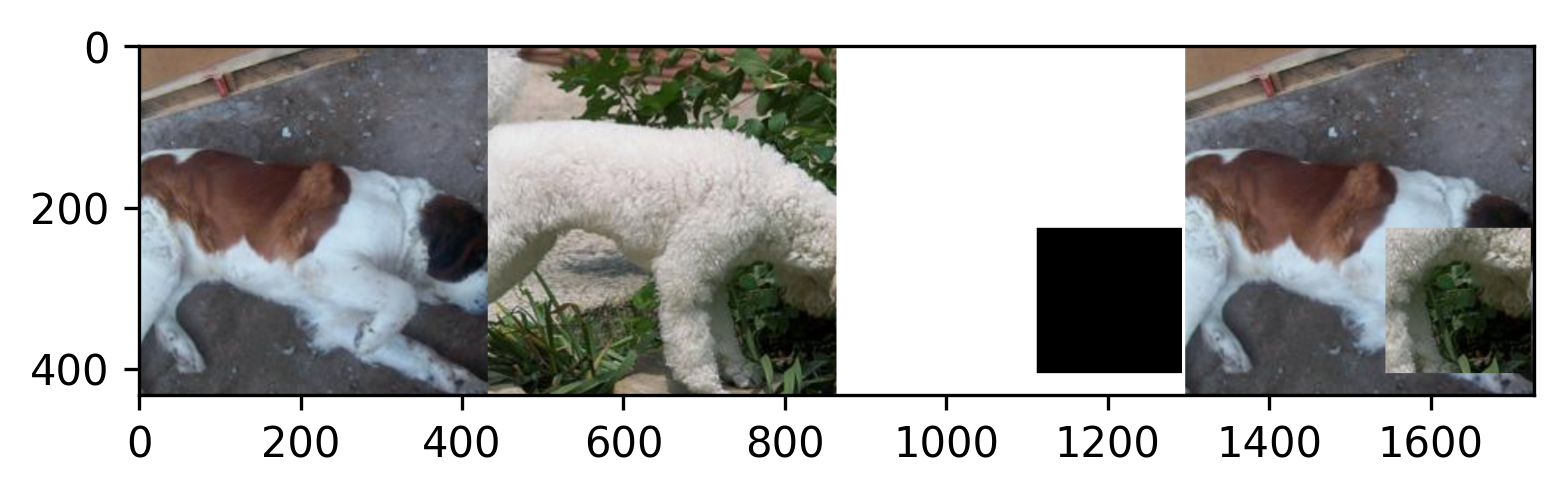

λ = 0.8245201736973794
yA = [1 0], yB = [0 1] and combine y = [0.82452017 0.17547983]


In [2]:
xA = cv2.imread('bernard.png')
yA = np.array([1,0])
xB = cv2.imread('poodle.png')
yB = np.array([0,1])

h,w = xA.shape[:2]
lambda_ = np.random.uniform(0, 1)

rw = int(w*np.sqrt(1-lambda_))
rh = int(h*np.sqrt(1-lambda_))
rx = int(np.random.uniform(0,w-rw))
ry = int(np.random.uniform(0,h-rh))

M = np.ones(shape=(h,w,3))
M[ry:ry+rh,rx:rx+rw] = np.zeros(shape=(rh,rw,3))

x = M*xA + (1-M)*xB
y = lambda_*yA + (1-lambda_)*yB

print(f"List of images: xA, xB, M and combine x")
plt.imshow(Image.fromarray(np.hstack((xA,xB,M*255,x))[...,::-1].astype(np.uint8)))
plt.show()
print(f"λ = {lambda_}")
print(f"yA = {yA}, yB = {yB} and combine y = {y}")

Class Activation Mapping (CAM) là một phương pháp được sử dụng để có thể trực quan hóa các vùng mô hình tập trung trên ảnh bằng bản đồ nhiệt. Hình ảnh được sử dụng bao gồm các phần của ảnh thuộc 2 class lần lượt là chó Saint Bernard và chó Miniature Poodle. Mô hình được sử dụng là ResNet50 và được huấn luyện trên tập dữ liệu sử dụng phương pháp CutMix. Phương pháp đề xuất có khả năng học chính xác tại vị trí của 2 class một cách chính xác và hiệu quả. Trong khi đó, 2 phương pháp liên quan là Mixup và Cutout nhầm lẫn khi chọn đúng vùng đặc trưng của các đối tượng. Sự nhầm lẫn này dẫn đến khả năng của các mô hình không được tối ưu trong các bài toán liên quan như phân loại đối tượng và xác định vị trí đối tượng.<br>
Hình ảnh ở dưới mô tả mô hình được huấn luyện với phương pháp CutMix có khả năng học đúng và chính xác các đặc trưng của từng đối tượng. Ví dụ được thử nghiệm trên ảnh $\tilde{x}$ được tạo ở trên.


List of images: x, CAM for Bernard and CAM for Poodle


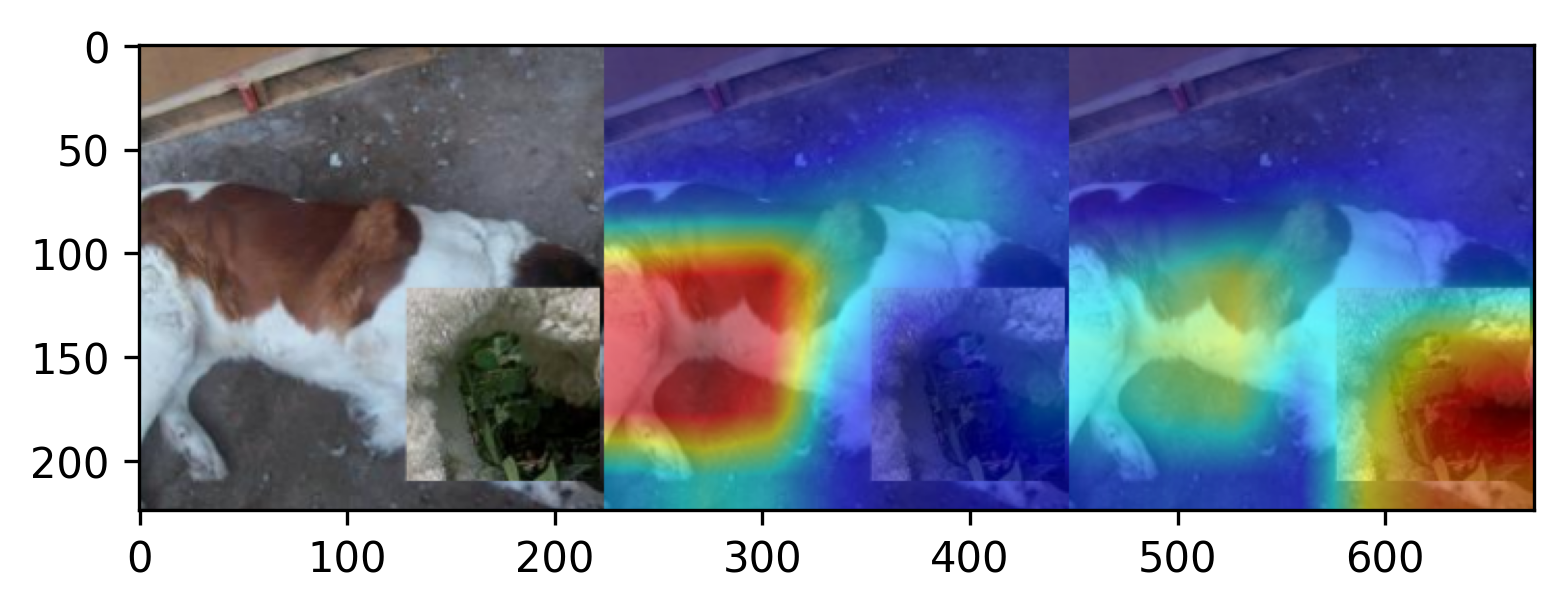

In [3]:
model = RN.ResNet('imagenet', 50, 1000, True)  # for ResNet
model = torch.nn.DataParallel(model)
checkpoint = torch.load('checkpoints/model_best.pth.tar',map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])

input_tensor = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
          ])(x.astype(np.uint8)).unsqueeze(0)

target_layers = [model.module.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

targets = [ClassifierOutputTarget(247)]# 247 for bernard
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = 1-grayscale_cam[0, :]
bernard = show_cam_on_image(cv2.resize(x,(224,224))/255., 
                                  grayscale_cam, use_rgb=True)

targets = [ClassifierOutputTarget(267)]#267 for poodle
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = 1-grayscale_cam[0, :]
poodle = show_cam_on_image(cv2.resize(x,(224,224))/255., 
                                  grayscale_cam, use_rgb=True)

print(f"List of images: x, CAM for Bernard and CAM for Poodle")
plt.imshow(Image.fromarray(np.hstack((cv2.resize(x,(224,224)),bernard,poodle))[...,::-1].astype(np.uint8)))
plt.show()

# 4. Phân tích và Đánh giá

## Bài toán Phân loại đối tượng

Phương pháp đề xuất CutMix được đánh giá trên tập dữ liệu ImageNet-1k. Tập dữ liệu ImageNet-1k bao gồm 1.2 triệu ảnh cho việc huấn luyện và 50 nghìn ảnh cho việc đánh giá phương pháp. Các phương pháp được so sánh sử dụng cùng cấu hình cho việc huấn luyện trên tập dữ liệu ImageNet-1k để việc so sánh được chính xác nhất. Khi so sánh với các phương pháp tương tự là StochDepth, DropBlock, Cutout và Mixup, phương pháp đề xuất CutMix đạt kết quả tốt nhất khi sử dụng các thông số đánh giá trên tập dữ liệu ImageNet-1k. Kết quả được hiển thị theo bảng dưới (Các thông số càng thấp càng tốt). Phương pháp CutMix vượt trội hơn các phương pháp liên quan và tốt nhất.

In [4]:
imagenet_table = """Model	Parameters	Top-1 Error (%)	Top-5 Error (%)
ResNet-50 Baseline	25.6m	23.68	7.05
ResNet-50 + Cutout	25.6m	22.93	6.66
ResNet-50 + Mixup	25.6m	22.58	6.4
ResNet-50 + StochDepth	25.6m	22.46	6.27
ResNet-50 + DropBlock	25.6m	21.87	5.98
ResNet-50 + CutMix	25.6m	21.4	5.92"""
df = pd.read_csv(io.StringIO(imagenet_table), sep="\t")
display(df)

,Model,Parameters,Top-1 Error (%),Top-5 Error (%)
0,ResNet-50 Baseline,25.6m,23.68,7.05
1,ResNet-50 + Cutout,25.6m,22.93,6.66
2,ResNet-50 + Mixup,25.6m,22.58,6.40
3,ResNet-50 + StochDepth,25.6m,22.46,6.27
4,ResNet-50 + DropBlock,25.6m,21.87,5.98
5,ResNet-50 + CutMix,25.6m,21.40,5.92


Phương pháp CutMix cũng được đánh giá trên một tập dữ liệu phổ biến khác là tập dữ liệu CIFAR-10. Trên tập dữ liệu này, phương pháp CutMix cải thiện khả năng phân loại đối tượng so với các phương pháp trước đó 0.97%, vượt trội hơn so với các phương pháp liên quan. Các phương pháp được đánh giá trên mô hình PyramidNet-200 với cùng cấu hình huấn luyện. Kết quả được hiển thị theo bảng dưới (Các thông số càng thấp càng tốt).

In [5]:
cifar_table = """Model	Parameters	Top-1 Error (%)	Top-5 Error (%)
PyramidNet-200 Baseline	26.8m	16.45	3.69
PyramidNet-200 + Cutout	26.8m	16.53	3.65
PyramidNet-200 + Mixup	26.8m	15.63	3.99
PyramidNet-200 + StochDepth	26.8m	15.86	6.27
PyramidNet-200 + DropBlock	26.8m	15.73	3.26
PyramidNet-200 + CutMix	26.8m	14.47	2.97"""
df = pd.read_csv(io.StringIO(cifar_table), sep="\t")
display(df)

,Model,Parameters,Top-1 Error (%),Top-5 Error (%)
0,PyramidNet-200 Baseline,26.8m,16.45,3.69
1,PyramidNet-200 + Cutout,26.8m,16.53,3.65
2,PyramidNet-200 + Mixup,26.8m,15.63,3.99
3,PyramidNet-200 + StochDepth,26.8m,15.86,6.27
4,PyramidNet-200 + DropBlock,26.8m,15.73,3.26
5,PyramidNet-200 + CutMix,26.8m,14.47,2.97


## Bài toán Xác định vị trí đối tượng

Trong bài toán Xác định vị trí đối tượng sử dụng các mô hình học một phần (weakly supervised object location)(WSOL), các bài toán này huấn luyện các mô hình phân loại đối tượng và xác định vị trí của đối tượng dựa vào loại của đối tượng được phân loại. Để có thể xác định vị trí đối tượng một cách chính xác nhất, các mô hình phân loại phải tìm được đúng vị trí của vật để có thể học được các đặc trưng. Các vị trí đó phải là toàn bộ đối tượng và không được tập trung vào đặc trưng tại một phần của đối tượng. Từ đó vị trí của đối tượng mới có thể được xác định đúng nhất.<br>
Có thể lấy ví dụ như phương pháp Class Activation Mapping ở trên. Các mô hình phân loại đúng các đối tượng, sau đó có thể tính được vị trí mà mô hình học được từ đối tượng đó. Từ đó có thể suy ra vị trí của đối tượng được phân loại đúng.<br>
Phương pháp đề xuất CutMix hướng dẫn các mô hình phân loại học trên các vùng đặc trưng rộng hơn để đưa ra quyết định đối tượng thuộc loại nào ở đầu ra. Phương pháp được sử dụng để tăng khả năng của các mô hình xác định vị trí WSOL.<br>
Để đánh giá được tính hiệu quả của mô hình với phương pháp CutMix, các cài đặt được triển khai dựa trên các mô hình WSOL gốc. Các mô hình gốc được chọn để thực hiện đánh giá là VGG-GAP và ResNet-50. Kết quả được đánh giá trên độ chính xác vị trí của các đối tượng được thể hiện như bảng dưới (Độ chính xác càng cao càng tốt). Các tập dữ liệu được sử dụng là CUB200-2011 và ImageNet.

In [6]:
wsol_table = """Model	CUB200-2011 Acc (%)	ImageNet Acc (%)
ResNet-50 Baseline	49.41	46.30
ResNet-50 + Cutout	52.78	46.69
ResNet-50 + Mixup	49.30	45.84
ResNet-50 + CutMix	54.81	47.25"""
df = pd.read_csv(io.StringIO(wsol_table), sep="\t")
display(df)

,Model,CUB200-2011 Acc (%),ImageNet Acc (%)
0,ResNet-50 Baseline,49.41,46.30
1,ResNet-50 + Cutout,52.78,46.69
2,ResNet-50 + Mixup,49.30,45.84
3,ResNet-50 + CutMix,54.81,47.25


# 5. Kết luận

Phương pháp được đề xuất CutMix được giới thiệu với khả năng huấn luyện được các mô hình trí tuệ nhân tạo với độ chính xác cao trong các bài toán điển hình như phân loại và xác định vị trí đối tượng. Phương pháp có tính dễ triển khai và không tốn nhiều tài nguyên để tính toán, trong khi đó vẫn có tác dụng cải thiện các mô hình trong nhiều nhiệm vụ khác nhau. Phương pháp cải thiện độ chính xác của các mô hình từ 1.70% đến 2.28% trên tập dữ liệu phân loại đối tượng ImageNet. Với tập dữ liệu CIFAR, phương pháp cải thiện khả năng của các mô hình tốt nhất 1.98% khi so sánh với mô hình gốc. Trong các bài toán xác định vị trí đối tượng, CutMix cải thiện đáng kể độ chính xác của vị trí và đạt được vị trí là phương pháp tốt nhất trong các phương pháp WSOL.